# Gaussian on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \mu \sim \mathcal{N}(0, 3^2),\qquad \log\sigma \sim \mathcal{N}(0, 1^2)$$

- The local parameters are different for each grid point
$$ \theta_{i,j} \sim \mathcal{N}(\mu, \sigma^2)$$

-  In each grid point, we have a Brownian motion with drift:
$$ dx_t = \theta \cdot dt + \sqrt{dt} \cdot dW_t$$
- We observe $T=10$ time points for each grid point over a time horizon of `max_time=1`. We can also amortize over the time dimension.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, weighting_function, euler_maruyama_sampling, adaptive_sampling, \
    probability_ode_solving, langevin_sampling, \
    generate_diffusion_time, count_parameters, train_hierarchical_score_model
from problems.gaussian_grid import GaussianGridProblem, Prior, Simulator, visualize_simulation_output, plot_shrinkage, \
    generate_synthetic_data

In [ ]:
torch_device = torch.device("cpu")

In [ ]:
prior = Prior(n_time_points=10)
simulator_test = Simulator(n_time_points=10)

# test the simulator
sim_test = simulator_test(prior.sample_full(1, n_grid=8))['observable']
visualize_simulation_output(sim_test)

In [ ]:
batch_size = 128
max_number_of_obs = 1  # larger than one means we condition the score on multiple observations

dataset = GaussianGridProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs,
    amortize_time=False
)

dataset_valid = GaussianGridProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [ ]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x=1,
    hidden_dim=64,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=True,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)

print(score_model.name)
count_parameters(score_model)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

In [ ]:
# train model
loss_history = train_hierarchical_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                              epochs=500, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [ ]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

In [ ]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error_w_local = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error_w_local[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, theta_local_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            theta_local_batch = theta_local_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)
            epsilon_local = torch.randn_like(theta_local_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            snr = score_model.sde.get_snr(t=t_tensor)
            alpha, sigma = score_model.sde.kernel(log_snr=snr)
            z_global = alpha * theta_global_batch + sigma * epsilon_global
            if score_model.max_number_of_obs > 1:
                # global params are not factorized to the same level as local params
                alpha_local = alpha.unsqueeze(1)
                sigma_local = sigma.unsqueeze(1)
            else:
                alpha_local = alpha
                sigma_local = sigma
            z_local = alpha_local * theta_local_batch + sigma_local * epsilon_local

            # predict from perturbed theta
            pred_epsilon_global, pred_epsilon_local = score_model(theta_global=z_global, theta_local=z_local,
                                       time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global, pred_score_local = score_model(theta_global=z_global, theta_local=z_local,
                                     time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)
            if score_model.max_number_of_obs == 1:
                true_score_local = score_model.sde.grad_log_kernel(x=z_local,
                                                                   x0=theta_local_batch,
                                                                   t=t_tensor)
            else:
                true_score_local = []
                for i in range(score_model.max_number_of_obs):
                    score_local = score_model.sde.grad_log_kernel(x=z_local[:, i],
                                                                   x0=theta_local_batch[:, i],
                                                                   t=t_tensor)
                    true_score_local.append(score_local.unsqueeze(1))
                true_score_local = torch.concatenate(true_score_local, dim=1)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
                target_local = -epsilon_local / sigma_local
                pred_target_local = -pred_epsilon_local / sigma_local
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
                target_local = epsilon_local
                pred_target_local = pred_epsilon_local
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
                target_local = alpha_local*epsilon_local - sigma_local * theta_local_batch
                pred_target_local = alpha_local*pred_epsilon_local - sigma_local * theta_local_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
                target_local = theta_local_batch
                pred_target_local = (z_local - pred_epsilon_local * sigma_local) / alpha_local
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_target_local - target_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_score_local - true_score_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(w * torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            #loss = loss_global + loss_local
            loss_list_error_w_global[t.item()] += loss_global.item()
            loss_list_error_w_local[t.item()] += loss_local.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_error[t.item()] += loss.item()

In [ ]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_local = pd.DataFrame(loss_list_error_w_local.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_local['Time'], np.log(df_error_w_local['Loss']), label='Local Weighted Loss')
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Global Weighted Loss')
ax[2].plot(df_error_w_local['Time'], np.log(df_error_w_local['Loss']+df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [ ]:
n_grid = 8
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior, n_samples=10, grid_size=n_grid,
                                                                            n_time_points=10,
                                                                            normalize=False, random_seed=0)
n_post_samples = 10
param_names = [r'$\mu$', r'$\log \sigma$']
#score_model.current_number_of_obs = 4  # we can choose here, how many observations are passed together through the score

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                   diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler.png')

In [ ]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                        diffusion_steps=1000, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler.png')

In [ ]:
mini_batch_size = 10
t1_value = mini_batch_size /( (n_grid*n_grid) //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t1_value + (t0_value - t1_value) * 0.5 * (1 + torch.cos(torch.pi * t)),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * score_model.sde.kernel(log_snr=score_model.sde.get_snr(t))[1],
    'damping_factor': lambda t: 0.1, #t1_value,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * torch.sigmoid(20*(t-0.3))
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

In [ ]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                         mini_batch_arg=mini_batch_arg,
                                                         diffusion_steps=200, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [ ]:
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [ ]:
posterior_global_samples_valid = probability_ode_solving(score_model, valid_data, n_post_samples=n_post_samples,
                                                         run_sampling_in_parallel=False,
                                                         device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode.png')

In [ ]:
conditions_global = (np.median(posterior_global_samples_valid, axis=0), posterior_global_samples_valid)[1]
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                        n_post_samples=n_post_samples, conditions=conditions_global,
                                                        diffusion_steps=50, device=torch_device, verbose=True)

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [ ]:
#conditions_global = np.median(posterior_global_samples_valid, axis=1)
posterior_local_samples_valid = probability_ode_solving(score_model, valid_data, n_post_samples=n_post_samples,
                                                        run_sampling_in_parallel=False,
                                                        conditions=posterior_global_samples_valid, device=torch_device, verbose=True)

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [ ]:
plot_shrinkage(posterior_global_samples_valid, posterior_local_samples_valid)

In [ ]:
valid_id = 2
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log sigma:', valid_prior_global[valid_id][1].item())

In [ ]:
med = np.median(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
std = np.std(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
error = (med-valid_prior_local[valid_id].numpy())**2
visualize_simulation_output(np.stack((med, valid_prior_local[valid_id], )),
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)), title_prefix=['Uncertainty', 'Error'], same_scale=False)


plt.figure(figsize=(4, 4), tight_layout=True)
plt.errorbar(x=valid_prior_local[valid_id].flatten(), y=med.flatten(), yerr=1.96*std.flatten(), fmt='o')
plt.plot([np.min(med), np.max(med)], [np.min(med), np.max(med)], 'k--')
plt.axhline(np.median(posterior_global_samples_valid[valid_id, :], axis=0)[0], color='red', linestyle='--',
            label='Global posterior mean', alpha=0.75)
plt.ylabel('Prediction')
plt.xlabel('True')
plt.legend()
plt.show()

# Compare to STAN

In [31]:
global_posterior_stan = np.load('problems/grid/global_posterior.npy')[:, -100:]
local_posterior_stan = np.load('problems/grid/local_posterior.npy')[:, -100:]
true_global = np.load('problems/grid/true_global.npy')
true_local = np.load('problems/grid/true_local.npy')

n_grid_stan = int(np.sqrt(true_local.shape[1]))

test_data = []
for g, l in zip(true_global, true_local):
    sim_dict = {
        'mu': g[0].reshape(1,1),
        'log_sigma': g[1].reshape(1,1),
        'theta': l.reshape(1, n_grid_stan, n_grid_stan)
    }
    td = simulator_test(sim_dict)['observable']
    test_data.append(td)
test_data = np.concatenate(test_data)
test_data.shape

(100, 10, 4, 4)

In [59]:
mini_batch_arg = {
    'size': 10,
    #'damping_factor': lambda t: 0.1,
}
#score_model.sde.s_shift_cosine = 6
n_post_samples = 100
param_names = [r'$\mu$', r'$\log \sigma$']
local_param_names = [r'$\theta_{'+str(i)+'}$' for i in range(n_grid_stan**2)]
param_names_stan = ['STAN '+ p for p in param_names]

In [ ]:
score_model.sde.s_shift_cosine = 6
posterior_global_samples_test = adaptive_sampling(score_model, test_data, n_post_samples,
                                                  mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
score_model.sde.s_shift_cosine = 0
posterior_local_samples_test = euler_maruyama_sampling(score_model, test_data, n_post_samples,
                                                 conditions=posterior_global_samples_test,
                                                 #run_sampling_in_parallel=False,
                                                 diffusion_steps=50,
                                                 device=torch_device, verbose=True)

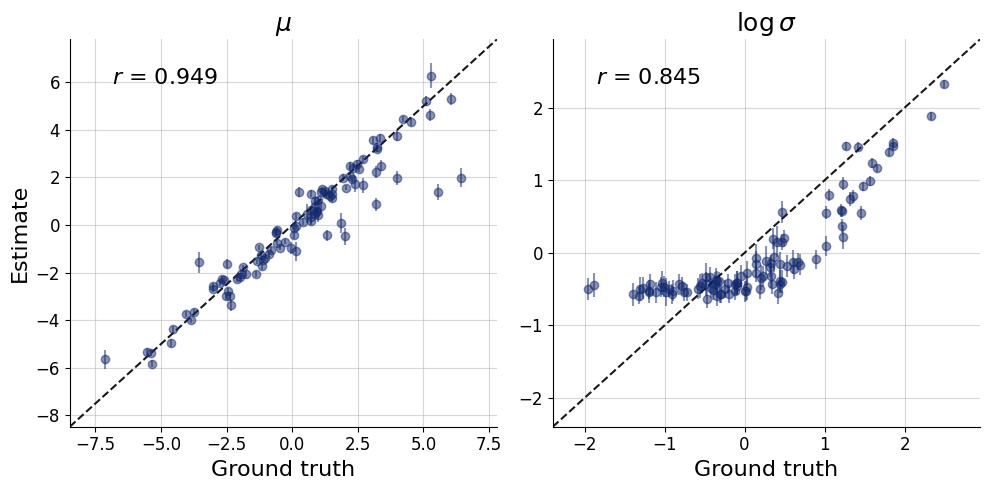

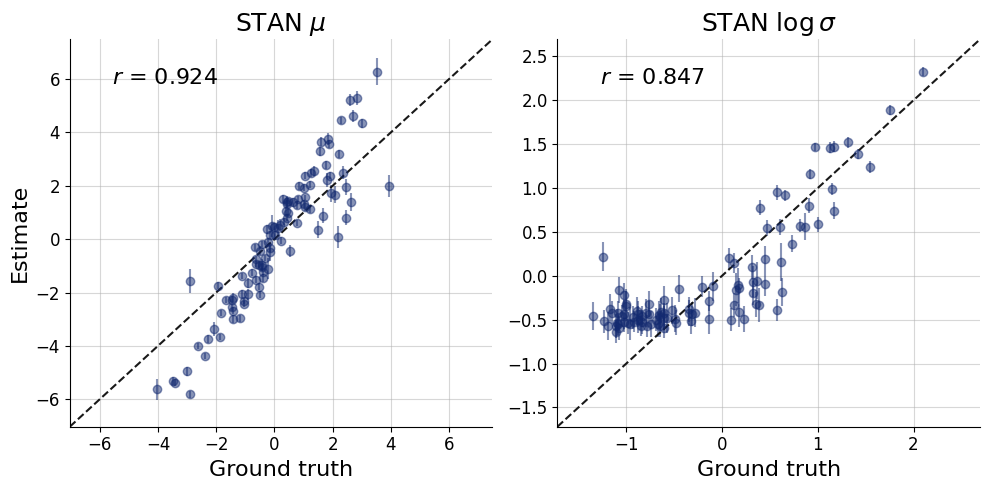

In [60]:
diagnostics.recovery(posterior_global_samples_test, true_global, variable_names=param_names)
diagnostics.recovery(posterior_global_samples_test, np.median(global_posterior_stan, axis=1), variable_names=param_names_stan);

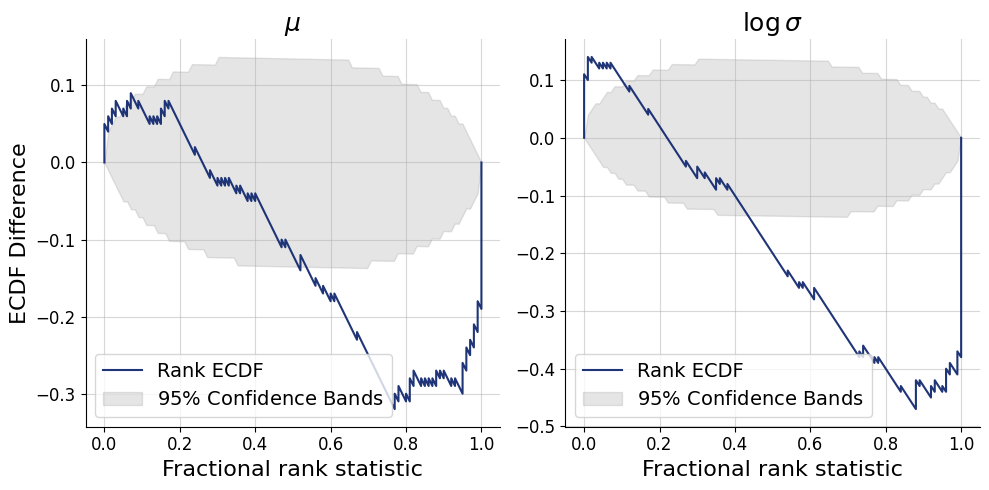

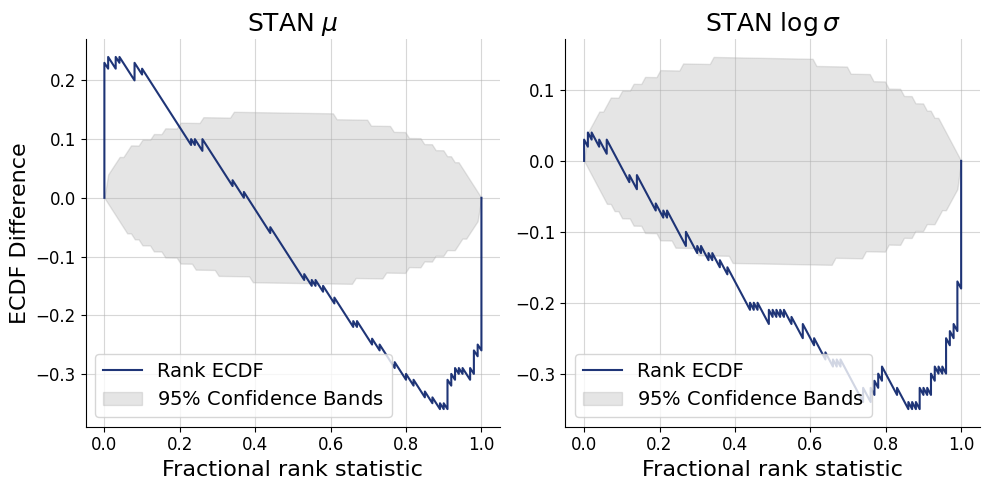

In [61]:
diagnostics.calibration_ecdf(posterior_global_samples_test, true_global, difference=True, variable_names=param_names)
diagnostics.calibration_ecdf(global_posterior_stan, true_global, difference=True, variable_names=param_names_stan);

In [62]:
global_posterior_stan.shape, local_posterior_stan.shape

((100, 100, 2), (100, 100, 16))

In [96]:
true_var[:10]

array([2.22624079, 1.03557654, 0.38444751, 0.31009939, 0.55945387,
       2.57151264, 2.295157  , 0.47215649, 3.38984273, 0.1933797 ])

In [95]:
np.var(true_local, axis=1)[:10]

array([1.51407647, 0.91809079, 0.13174843, 0.26492099, 0.39227365,
       4.06990106, 1.19790227, 0.6297439 , 3.60928017, 0.25862389])

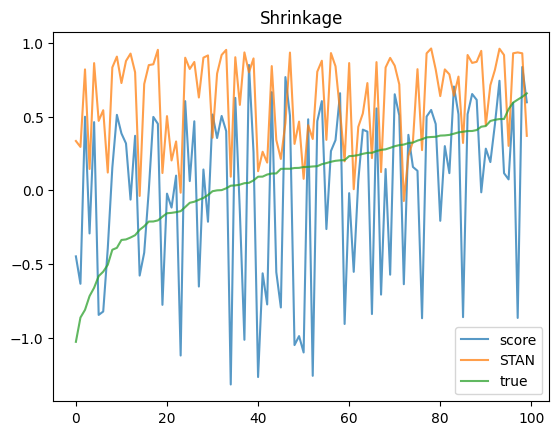

Correlation shrinkage score and STAN: 0.6497380380515416
Correlation shrinkage true and score: 0.18055615384833051
Correlation shrinkage true and STAN: 0.1294559452050859
Score shrinkage < STAN shrinkage: 92.0%


In [119]:
global_var = np.exp(np.median(posterior_global_samples_test, axis=1)[:, 1])[:, np.newaxis] ** 2
shrinkage = 1-np.var(np.median(posterior_local_samples_test, axis=1), axis=1)/global_var#[:, np.newaxis]

global_var_stan = np.exp(np.median(global_posterior_stan, axis=1)[:, 1])**2
shrinkage_stan = 1-np.var(np.median(local_posterior_stan, axis=1), axis=1)/global_var_stan

true_var = np.exp(true_global)[:, 1]**2
shrinkage_true = 1-np.var(true_local, axis=1)/true_var

s_order = np.argsort(shrinkage_true)
shrinkage = shrinkage.flatten()[s_order]
shrinkage_stan = shrinkage_stan.flatten()[s_order]
shrinkage_true = shrinkage_true[s_order]

min_s = -10
shrinkage[shrinkage < min_s] = min_s
shrinkage_stan[shrinkage_stan < min_s] = min_s
shrinkage_true[shrinkage_true < min_s] = min_s

plt.title('Shrinkage')
plt.plot(shrinkage, label='score', alpha=0.75)
plt.plot(shrinkage_stan, label='STAN', alpha=0.75)
plt.plot(shrinkage_true, label='true', alpha=0.75)
plt.legend()
plt.show()

print('Correlation shrinkage score and STAN:', np.corrcoef(shrinkage, shrinkage_stan)[0, 1])
print('Correlation shrinkage true and score:', np.corrcoef(shrinkage_true, shrinkage)[0, 1])
print('Correlation shrinkage true and STAN:', np.corrcoef(shrinkage_true, shrinkage_stan)[0, 1])

print(f"Score shrinkage < STAN shrinkage: {(shrinkage < shrinkage_stan).sum() / shrinkage.shape[0]*100}%")

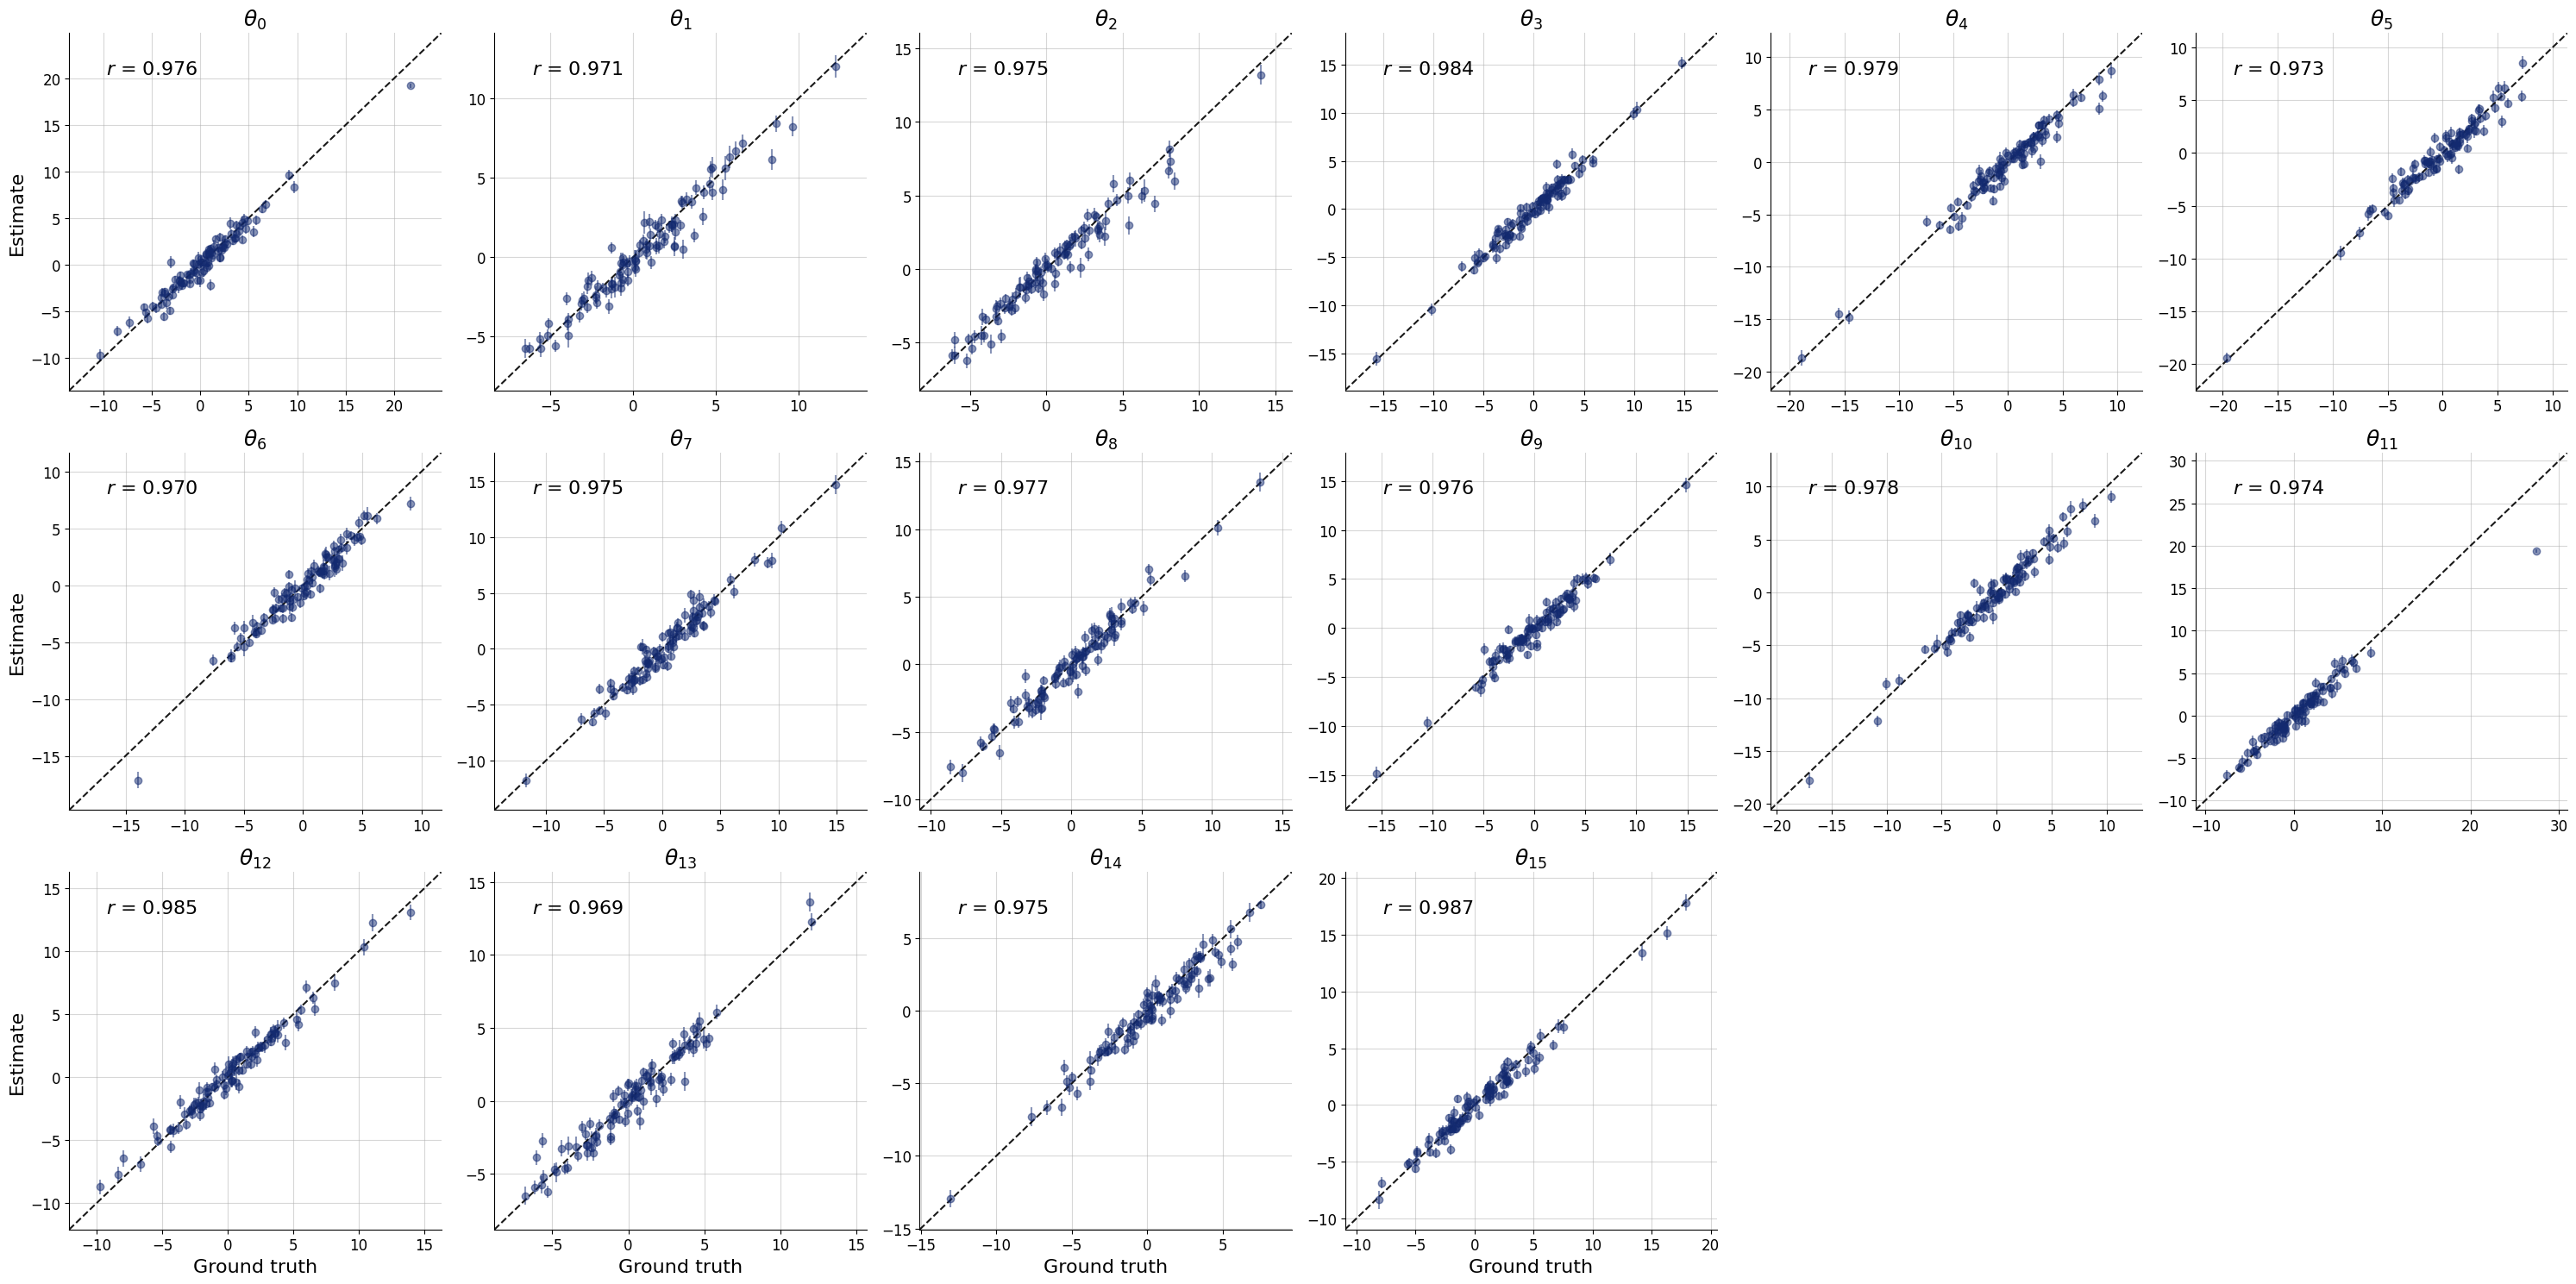

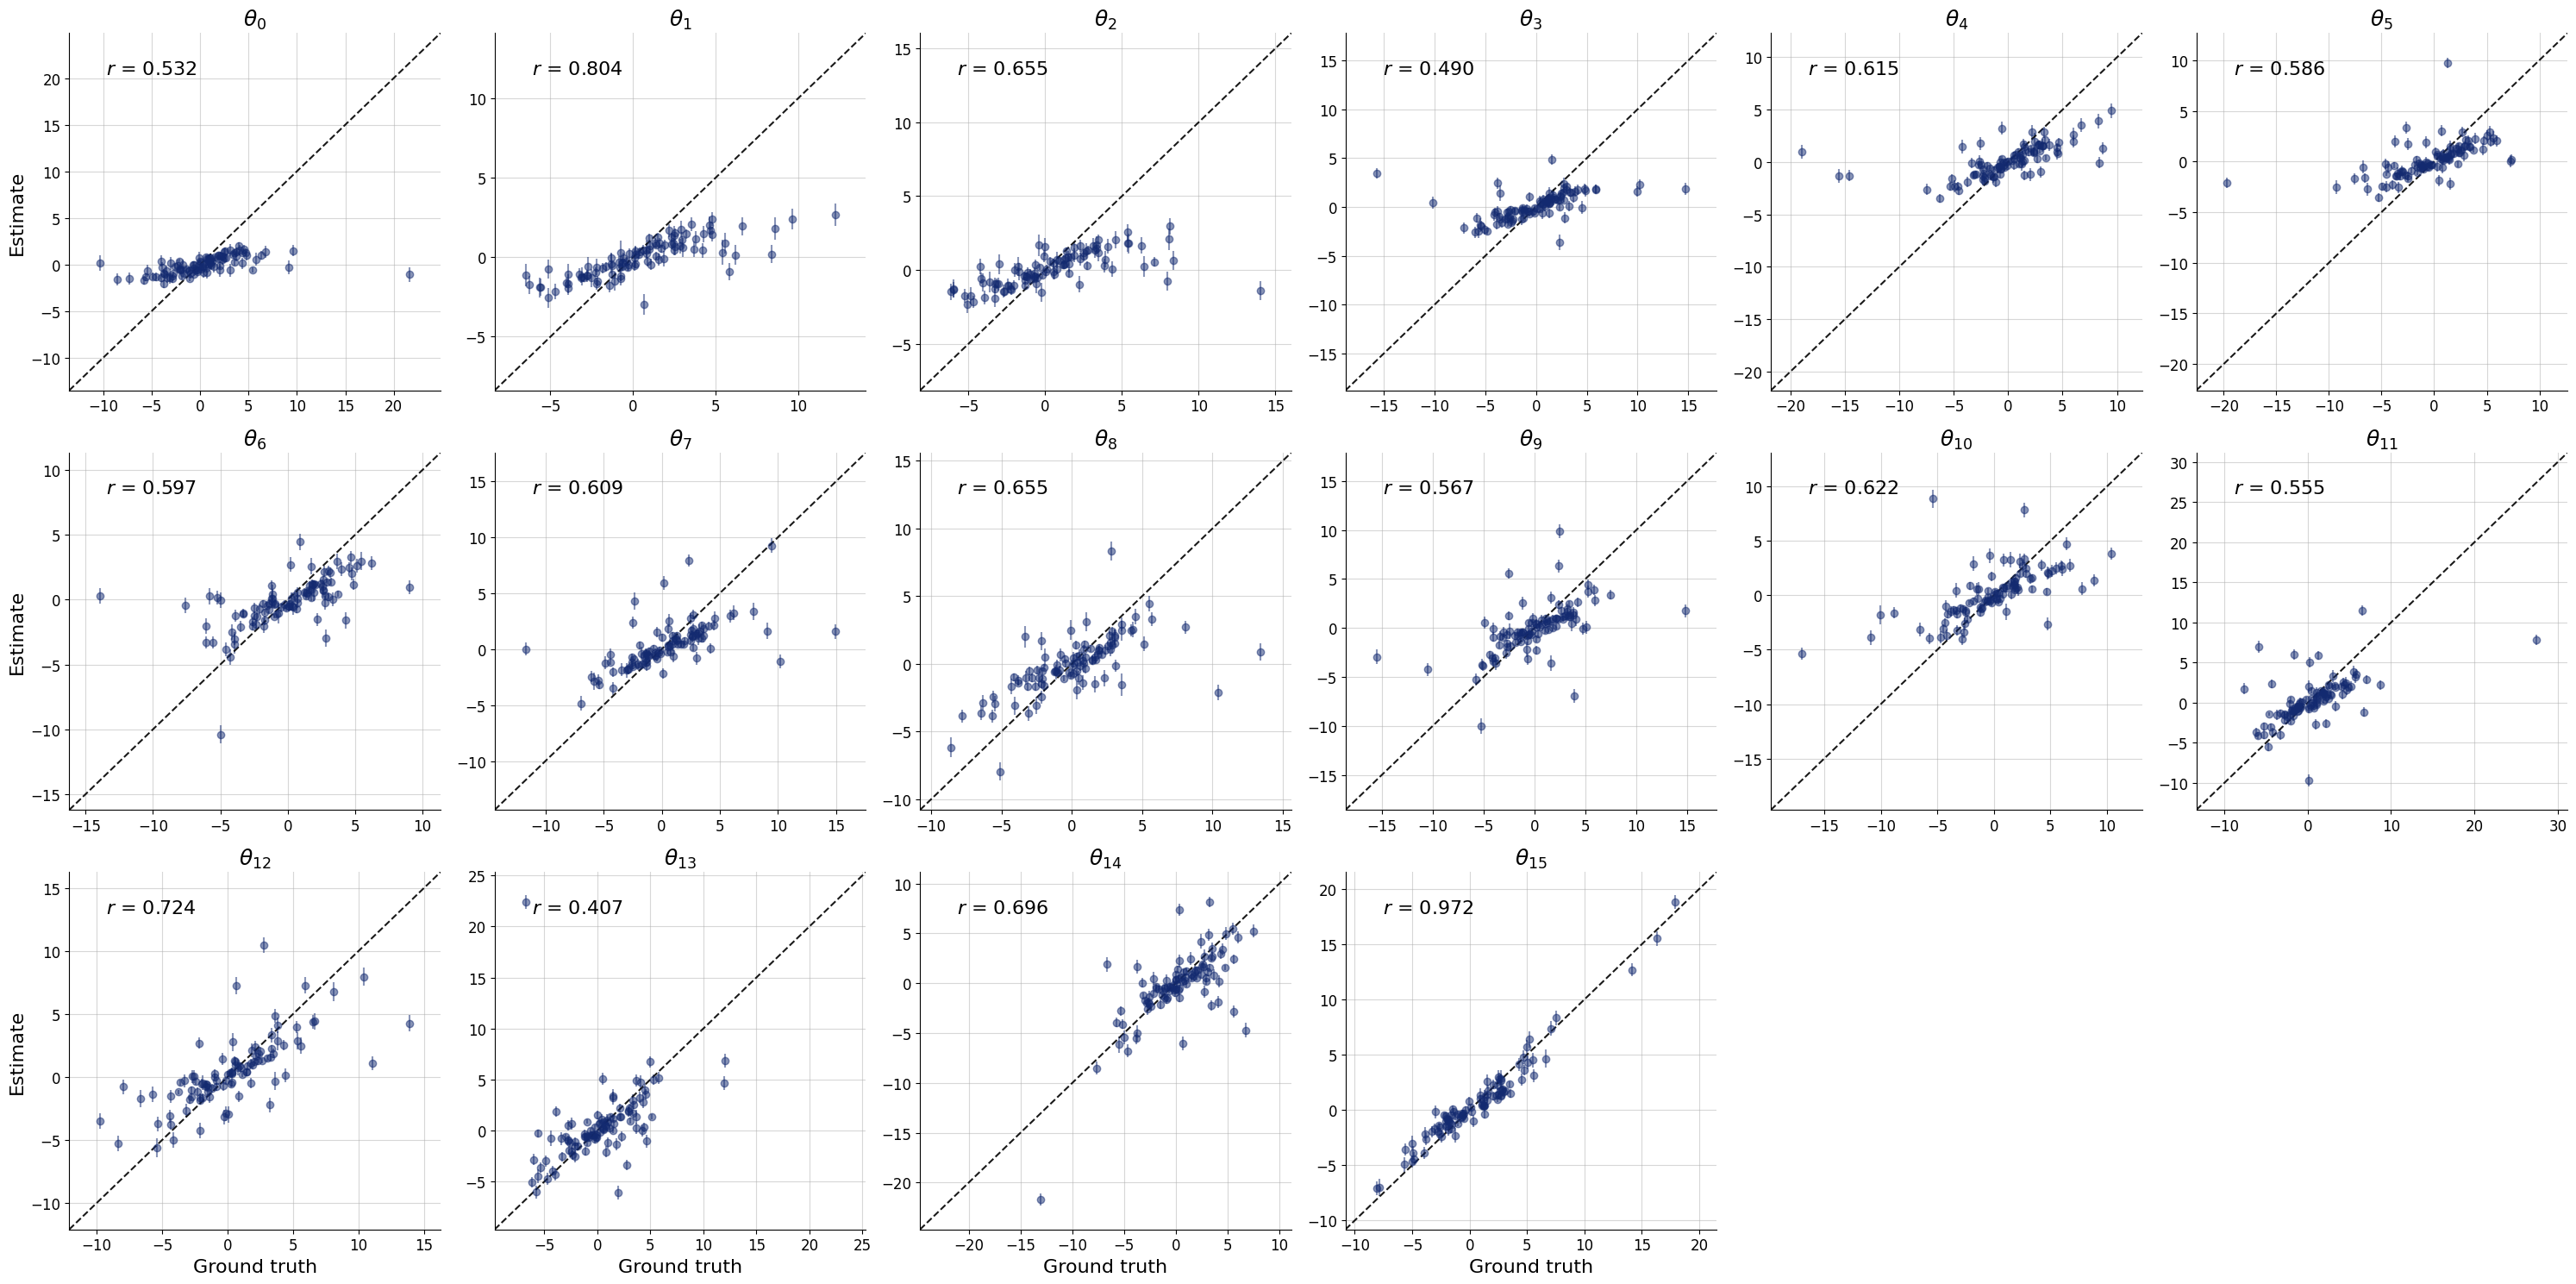

In [34]:
diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1), true_local,
                     variable_names=local_param_names)
diagnostics.recovery(local_posterior_stan, true_local, variable_names=local_param_names);

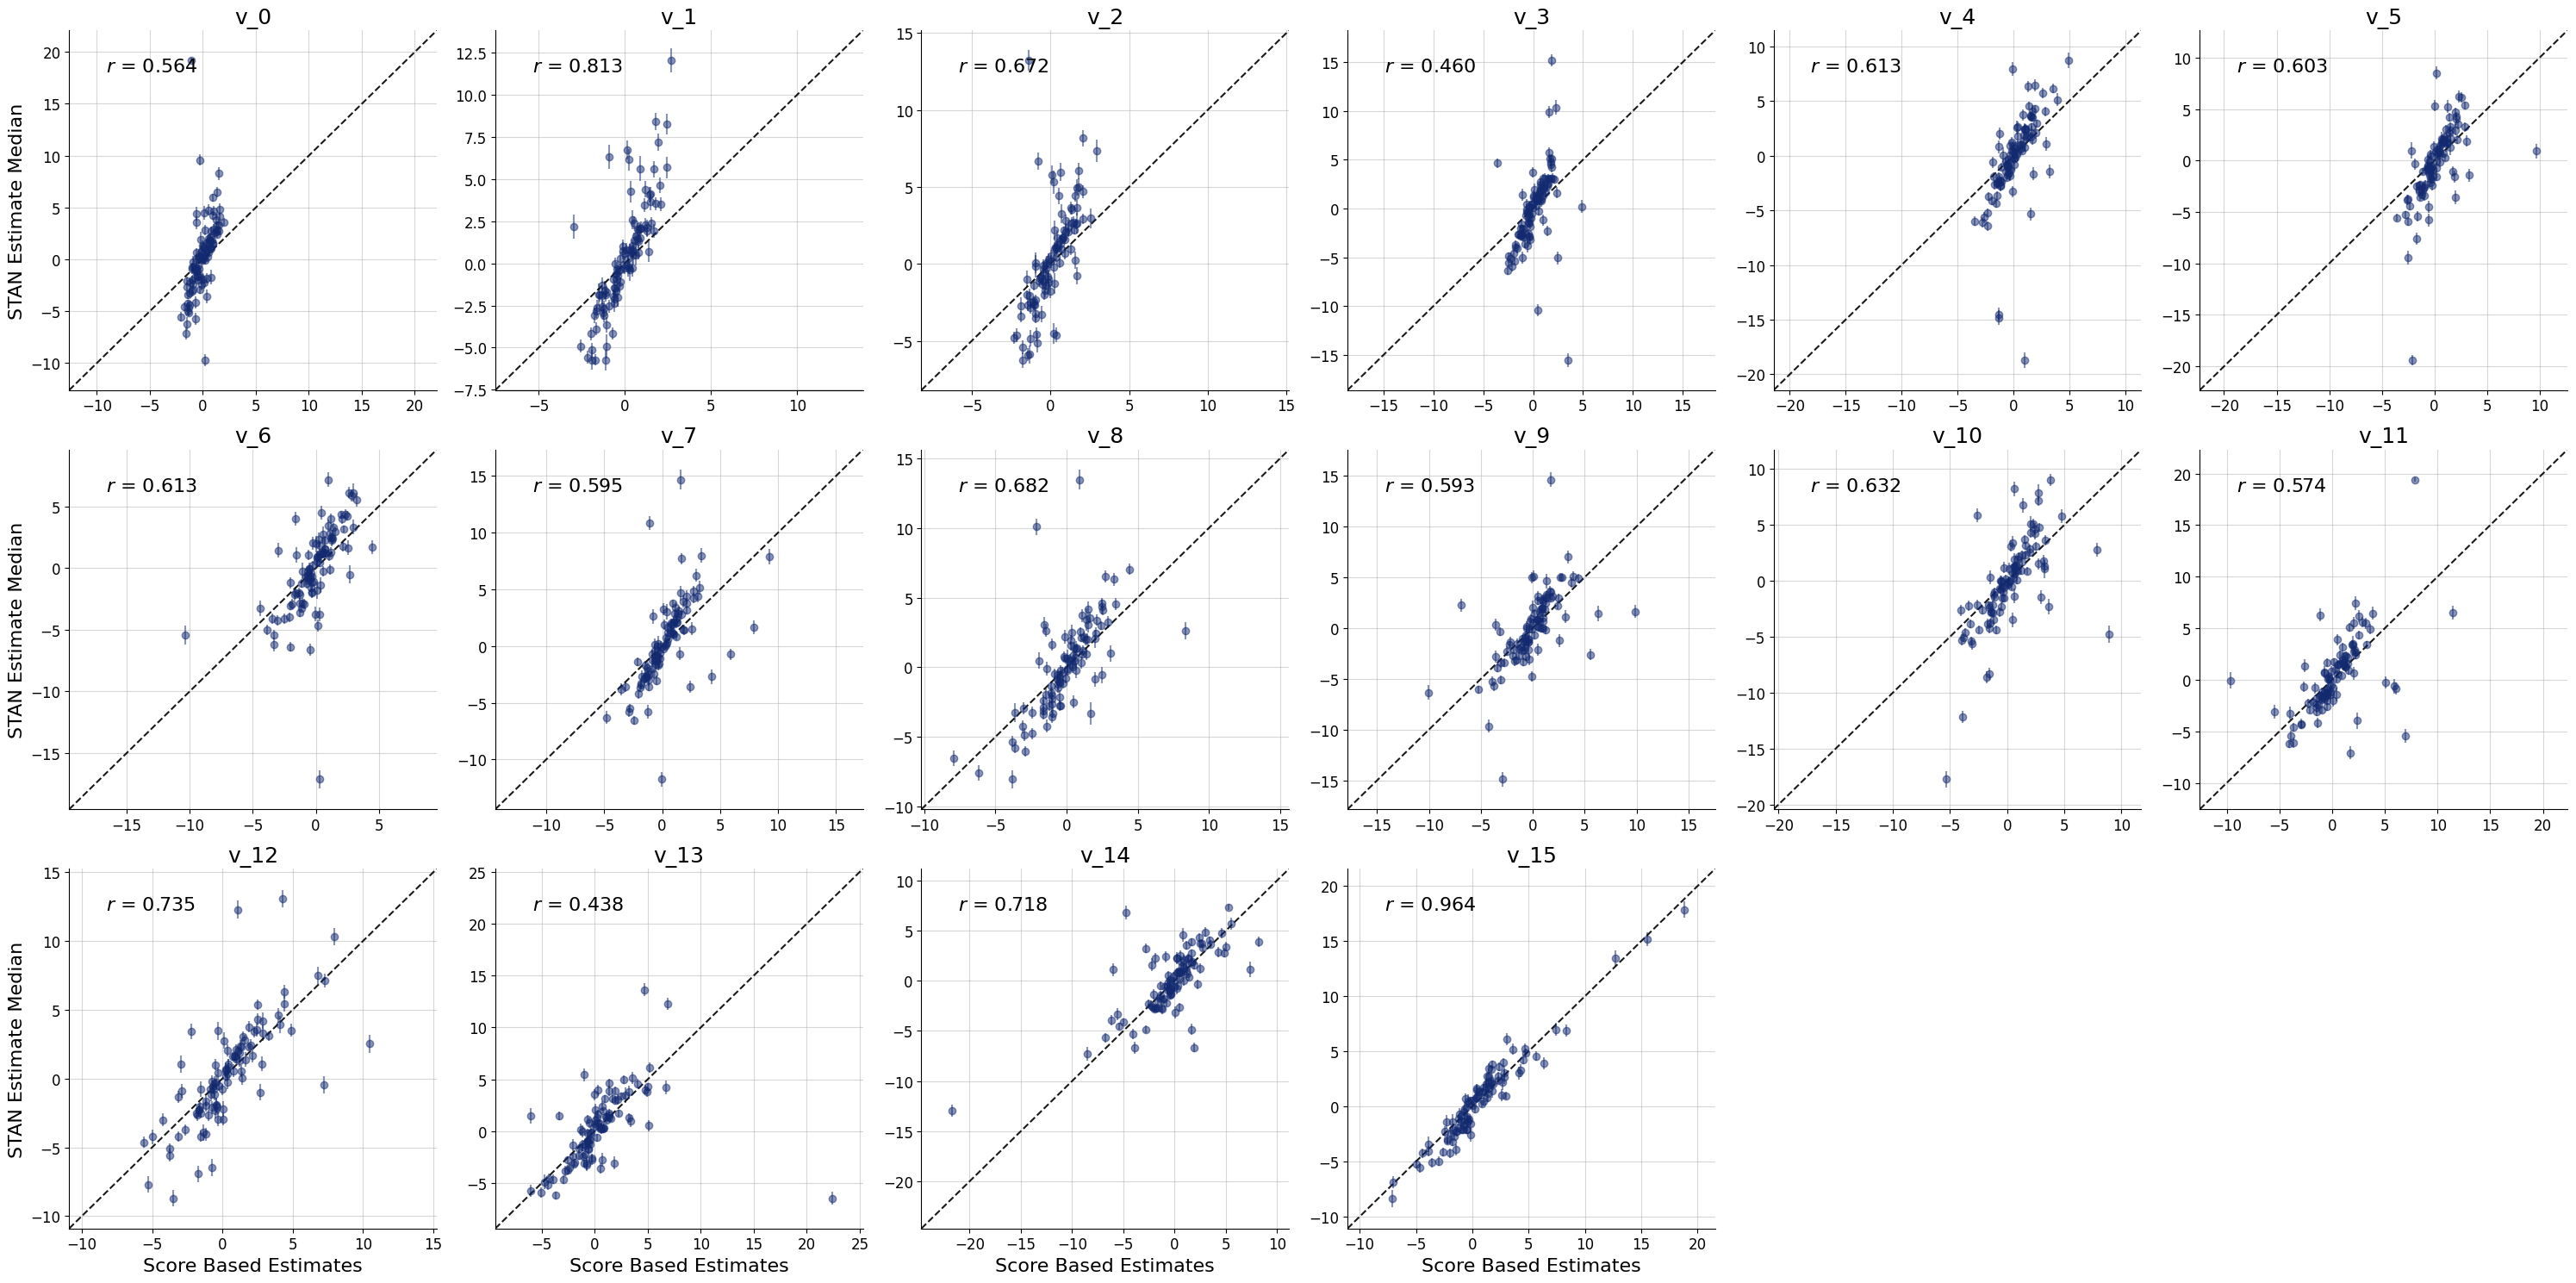

In [35]:
diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1),
                     np.median(local_posterior_stan, axis=1), xlabel='Score Based Estimates', ylabel='STAN Estimate Median');

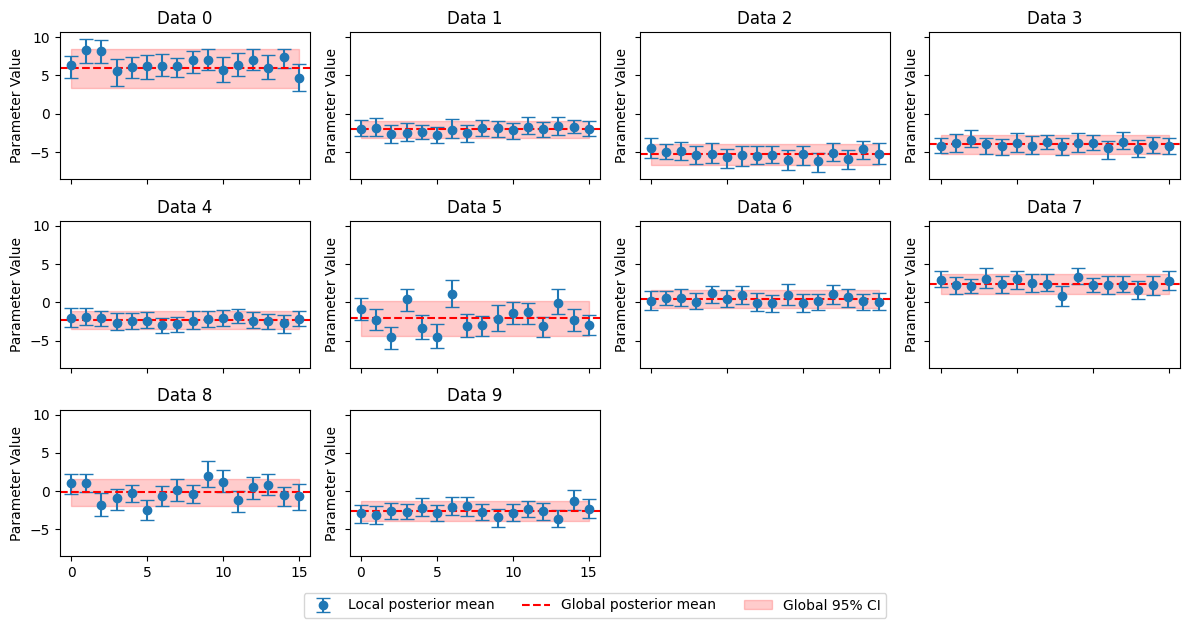

In [36]:
plot_shrinkage(posterior_global_samples_test[:10], posterior_local_samples_test[:, :, :, np.newaxis][:10])

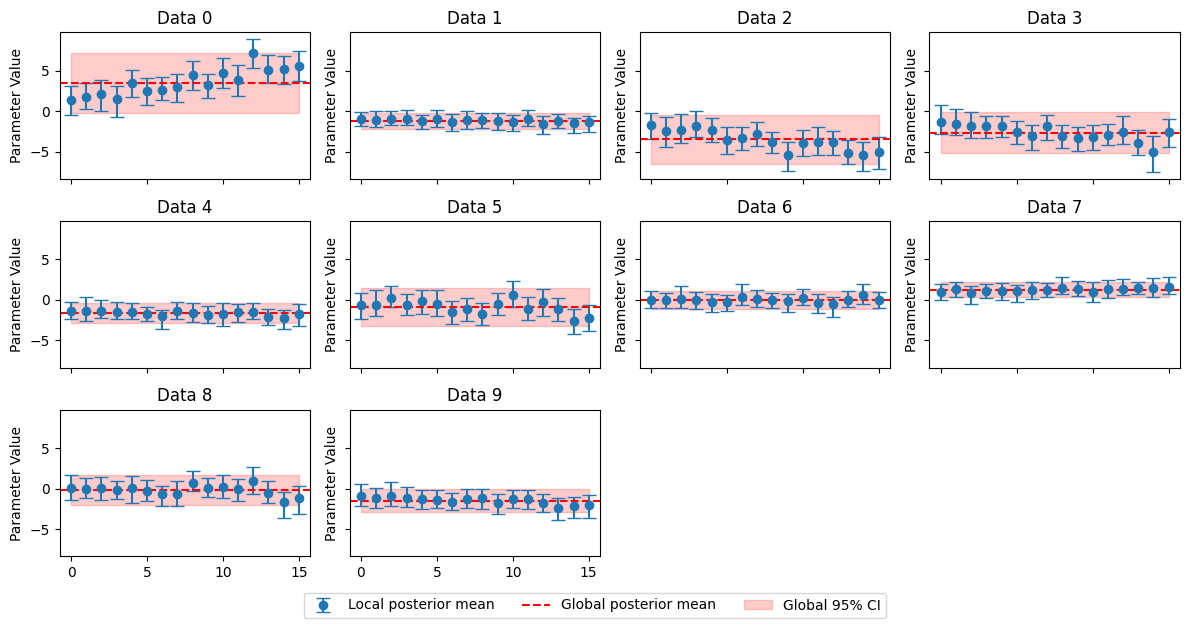

In [37]:
plot_shrinkage(global_posterior_stan[:10], local_posterior_stan[:, :, :, np.newaxis][:10])

# Visualize the Score

In [ ]:
n_grid = 8
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior, n_samples=10, grid_size=n_grid,
                                                                            normalize=False, random_seed=0)

valid_id = 3

diffusion_time = generate_diffusion_time(size=10, device=torch_device)
x_valid = valid_data[valid_id].to(torch_device)
x_valid_norm = score_model.prior.normalize_data(x_valid)
theta_global = score_model.prior.normalize_theta(valid_prior_global[valid_id], global_params=True).cpu().numpy()  # we normalize as the score is normalized space
print(valid_id, 'theta global', theta_global)

In [ ]:
test_sample = adaptive_sampling(score_model, x_valid[None], conditions=None, n_post_samples=1, #e_abs=0.00078,
                                t_end=0, random_seed=0, device=torch_device)
test_sample = score_model.prior.normalize_theta(torch.tensor(test_sample), global_params=True).cpu().numpy()
print(test_sample)

In [ ]:
posterior_sample_path = np.array([adaptive_sampling(score_model, x_valid[None],
                                                    conditions=None, n_post_samples=1, t_end=t,
                                                    random_seed=0, device=torch_device)
                                  for t in diffusion_time[:-1]])
# we normalize as the score is normalized space
posterior_sample_path = score_model.prior.normalize_theta(torch.tensor(posterior_sample_path), global_params=True).cpu().numpy()

posterior_sample_path2 = np.array([probability_ode_solving(score_model, x_valid[None],
                                                           conditions=None, n_post_samples=1, t_end=t, random_seed=0, device=torch_device)
                                  for t in diffusion_time[:-1]])
# we normalize as the score is normalized space
posterior_sample_path2 = score_model.prior.normalize_theta(torch.tensor(posterior_sample_path2), global_params=True).cpu().numpy()

print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Define grid boundaries and resolution for your 2D space.
x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5
grid_res = 10  # Number of points per dimension

# Create a meshgrid of points
x_vals = np.linspace(x_min, x_max, grid_res)
y_vals = np.linspace(y_min, y_max, grid_res)
xx, yy = np.meshgrid(x_vals, y_vals)
# Stack into (N,2) where N = grid_res*grid_res
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Convert grid to a torch tensor and move to device
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=torch_device)
x_valid_norm_e = x_valid_norm.reshape(10, -1).to(torch_device)
x_valid_norm_ext = x_valid_norm_e.unsqueeze(0).repeat(grid_tensor.shape[0], 1, 1)

# Dictionary to hold score outputs for each time
scores = {}
scores_smoothed = {}
drifts = {}
drifts_smoothed = {}

with torch.no_grad():
    # Evaluate the score model for each time value
    for t in diffusion_time:
        # Create a tensor of time values for each grid point
        t_tensor = torch.full((grid_tensor.shape[0], 1), t.item(), dtype=torch.float32, device=torch_device)
        epsilon = torch.randn_like(grid_tensor, dtype=torch.float32, device=torch_device)

        # perturb theta
        snr = score_model.sde.get_snr(t=t_tensor)
        alpha, sigma = score_model.sde.kernel(log_snr=snr)
        z = grid_tensor #alpha * grid_tensor + sigma * epsilon

        # Evaluate the score model
        score_indv = torch.zeros((x_valid_norm_ext.shape[2], grid_tensor.shape[0], 2))

        prior_scores = (1 - t) * score_model.prior.score_global_batch(z)
        prior_scores_indv = prior_scores.unsqueeze(0)
        for i in range(x_valid_norm_ext.shape[2]):
            score_indv[i] = score_model.forward_global(theta_global=z, time=t_tensor, x=x_valid_norm_ext[:, :, i].unsqueeze(-1),
                                                       pred_score=True, clip_x=False)
        score_indv = score_indv - prior_scores_indv

        score = score_indv.sum(axis=0)
        score = score + prior_scores
        scores[t.item()] = score.cpu().numpy()

        # score_pareto = torch.zeros_like(score)
        # for i in range(score_indv.shape[1]):
        #     score_pareto[i] = pareto_smooth_sum(score_indv[:, i].unsqueeze(0),
        #                                            tail_fraction=0.3)[0]  # expects dim to be the batch
        #
        # score_pareto = score_pareto + prior_scores
        # scores_smoothed[t.item()] = score_pareto.cpu().numpy()

        f, g = score_model.sde.get_f_g(x=z, t=t_tensor)
        drift = f - 0.5 * torch.square(g) * scores[t.item()]
        drifts[t.item()] = drift.cpu().numpy()

        # drift_pareto = f - 0.5 * torch.square(g) * scores_smoothed[t.item()]
        # drifts_smoothed[t.item()] = drift_pareto.cpu().numpy()

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, (t_val, score_val) in enumerate(sorted(scores.items(), reverse=True)):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = score_val[:, 0].reshape(grid_res, grid_res)
    V = score_val[:, 1].reshape(grid_res, grid_res)  # negative since we are plotting the reverse score

    ax = axes[i]

    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    if i != 0:
        j = i
        h2, = ax.plot(posterior_sample_path[:-j, 0, 0, 0], posterior_sample_path[:-j, 0, 0, 1], 'o-', label='Posterior Path Sampling', alpha=0.5)
        h4, = ax.plot(posterior_sample_path2[:-j, 0, 0, 0], posterior_sample_path2[:-j, 0, 0, 1], 'o-', label='Posterior Path ODE', alpha=0.5)
    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', scale=5*n_grid*n_grid, alpha=.75, label='Score')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5, h0, h1, h2, h4], loc='lower center', ncols=5, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/score.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, (t_val, score_val) in enumerate(sorted(drifts.items(), reverse=True)):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = score_val[:, 0].reshape(grid_res, grid_res)
    V = score_val[:, 1].reshape(grid_res, grid_res)

    ax = axes[i]
    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    j = len(diffusion_time)-i-1
    h2, = ax.plot(posterior_sample_path[j:, 0, 0, 0], posterior_sample_path[j:, 0, 0, 1], 'o-', label='Posterior Path Sampling', alpha=0.5)
    h4, = ax.plot(posterior_sample_path2[j:, 0, 0, 0], posterior_sample_path2[j:, 0, 0, 1], 'o-', label='Posterior Path ODE', alpha=0.5)
    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', scale=5*n_grid*n_grid, alpha=.75,
                   label='Probability Flow')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5, h0, h1, h2, h4], loc='lower center', ncols=5, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/drift.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

# Step Size for different Grid Sizes

In [ ]:
# check number of steps needed for different number of data points
n_steps = {}
n_steps_per_grid = {}
n_steps_rmse = {}
n_steps_calibration = {}
n_steps_contraction = {}

score_model.current_number_of_obs = 1 #max_number_of_obs
grid_sizes = [4, 8, 12, 16, 32]
#grid_sizes = [10, 20, 30, 40, 100] #[5, 10, 15, 30, 70] # [1, 3, 4, 10, 32]
mini_batch_arg = {
    'size': 10,
    'damping_factor': lambda t: 0.1,
}
sampling_types = [('normal', None), ('subsample', mini_batch_arg)]

for sampling_type in sampling_types:
    print(sampling_type)
    n_steps[sampling_type[0]] = []
    n_steps_per_grid[sampling_type[0]] = []
    n_steps_rmse[sampling_type[0]] = []
    n_steps_calibration[sampling_type[0]] = []
    n_steps_contraction[sampling_type[0]] = []
    for n in grid_sizes:
        true_params, _, valid_data = generate_synthetic_data(prior, n_samples=10, grid_size=n,
                                                   normalize=False, random_seed=0)
        test_sample, list_steps = adaptive_sampling(score_model, valid_data, conditions=None, n_post_samples=25,
                                                    mini_batch_arg=sampling_type[1],
                                                    run_sampling_in_parallel=False,
                                                    t_end=0, random_seed=0, device=torch_device,
                                                    return_steps=True)

        n_steps_per_grid[sampling_type[0]].append(list_steps)
        n_steps[sampling_type[0]].append(len(list_steps))

        rmse = diagnostics.root_mean_squared_error(test_sample, np.array(true_params))['values']
        n_steps_rmse[sampling_type[0]].append(rmse)

        cali = diagnostics.calibration_error(test_sample, np.array(true_params))['values']
        n_steps_calibration[sampling_type[0]].append(cali)

        contract = diagnostics.posterior_contraction(test_sample, np.array(true_params))['values']
        n_steps_contraction[sampling_type[0]].append(contract)

In [ ]:
plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(grid_sizes, n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different Grid Sizes ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('Grid Size')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(np.array(grid_sizes)**2/score_model.current_number_of_obs,
             n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different Grid Sizes ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('#Observations (divided by number of obs used to predict score)')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_n_obs{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(grid_sizes, n_steps_error[sampling_type[0]], 'o-', label=sampling_type[0])
plt.title('Error for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('Grid Size')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.savefig(f'plots/{score_model.name}/error_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

fig, ax = plt.subplots(1, len(sampling_types), sharey=True, figsize=(4*len(sampling_types), 4), tight_layout=True)
for a, sampling_type in zip(ax, sampling_types):
    a.set_title(sampling_type[0])
    for i, n in zip(grid_sizes, n_steps_per_grid[sampling_type[0]]):
        a.plot(n, label=f'{i}x{i}')
    a.set_xlabel('Step')
    a.set_ylabel('Step Size')
    a.set_yscale('log')
    a.legend(loc='lower right')
    a.set_ylim(1e-6, 1)
plt.savefig(f'plots/{score_model.name}/n_steps_per_grid{score_model.current_number_of_obs}.png')
plt.show()